<a href="https://colab.research.google.com/github/41371115h-dot/114-class-thursday2-4/blob/main/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80%E4%BD%9C%E6%A5%AD%E5%85%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.9 MB/s eta 0:00:00


In [29]:
!pip install gspread gspread_dataframe google-auth google-auth-oauthlib google-auth-httplib2 google-colab gradio google-genai

In [19]:
from google.colab import auth
auth.authenticate_user()

In [37]:
import pandas as pd
import gradio as gr
from datetime import datetime
import gspread
from gspread_dataframe import set_with_dataframe, get_as_dataframe
from google.auth import default
from google.colab import auth
from google import genai
from google.genai import types
import time

# Colab 認證
auth.authenticate_user()
SPREADSHEET_ID = "19xho0MmcY76NTco9T1bcyzcM7byBKpWtObOgZK12674"

# ------------------------------
# Google Sheets
# ------------------------------
def get_gspread_client():
    creds, _ = default()
    return gspread.authorize(creds)

def read_schedule_from_sheet(sheet_index=0):
    client = get_gspread_client()
    sh = client.open_by_key(SPREADSHEET_ID)
    worksheet = sh.get_worksheet(sheet_index)
    df = get_as_dataframe(worksheet, evaluate_formulas=True, empty2nan=False)
    df = df.fillna("")  # 空值填空字串，避免 Gradio 顯示錯誤
    return df, worksheet

def write_goal_and_advice_to_sheet(goal, advice, username="匿名使用者", sheet_index=0):
    client = get_gspread_client()
    sh = client.open_by_key(SPREADSHEET_ID)
    worksheet = sh.get_worksheet(sheet_index)
    df = get_as_dataframe(worksheet, evaluate_formulas=True, empty2nan=False)
    df = df.fillna("")
    row = {"Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
           "User": username,
           "Goal": goal,
           "AI_Advice": advice}
    if set(["Timestamp","User","Goal","AI_Advice"]).issubset(df.columns):
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    else:
        df = pd.DataFrame([row])
    set_with_dataframe(worksheet, df)
    return True

# ------------------------------
# AI 建議（只依目標，100字以內 + 重試機制）
# ------------------------------
def generate_advice(gemini_key, goal_text, retries=3, wait_sec=2):
    client = genai.Client(api_key=gemini_key)
    prompt = f"我有以下本週讀書目標：{goal_text}\n請用繁體中文100字以內，條列可執行學習計畫與短動機句。"

    for attempt in range(retries):
        try:
            response = client.models.generate_content(
                model="gemini-2.5-flash",
                contents=prompt,
                config=types.GenerateContentConfig(
                    temperature=0.2,
                    max_output_tokens=150
                )
            )
            # 正確抓取文字，避免 NoneType
            advice_text = ""
            if hasattr(response, "result") and response.result:
                advice_text = response.result[0].content[0].text
            if advice_text and advice_text.strip():
                return advice_text.strip()
        except Exception as e:
            if "503" in str(e) or "unavailable" in str(e).lower():
                time.sleep(wait_sec)  # 模型超載暫停再試
            else:
                return f"AI 建議生成錯誤：{e}"
    return "AI 伺服器繁忙或未回傳建議，請稍後再試。"

# ------------------------------
# Gradio UI
# ------------------------------
def generate_and_show(gemini_key, weekly_goal):
    df_sheet, _ = read_schedule_from_sheet()
    advice = generate_advice(gemini_key, weekly_goal)
    return df_sheet, advice

def save_callback(goal_text, advice_text):
    success = write_goal_and_advice_to_sheet(goal_text, advice_text)
    return "已成功寫入 Google Sheet" if success else "寫入失敗"

with gr.Blocks() as demo:
    gr.Markdown("## AI 讀書建議（依目標生成，100字以內）")

    schedule_df = gr.Dataframe(label="課表", interactive=False)
    weekly_goal = gr.Textbox(label="本週目標", lines=2, placeholder="例：完成線性代數第1-4章，練習10題")
    gemini_key_box = gr.Textbox(label="Gemini API Key", type="password")
    advice_box = gr.Textbox(label="AI 建議", lines=5)

    btn_generate = gr.Button("生成 AI 建議")
    btn_save = gr.Button("存回 Google Sheets")
    save_status = gr.Textbox(label="存回狀態", lines=2)

    btn_generate.click(fn=generate_and_show,
                       inputs=[gemini_key_box, weekly_goal],
                       outputs=[schedule_df, advice_box])
    btn_save.click(fn=save_callback,
                   inputs=[weekly_goal, advice_box],
                   outputs=[save_status])

if __name__=="__main__":
    demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://24e71298c3dab44db4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## **課表輸出**

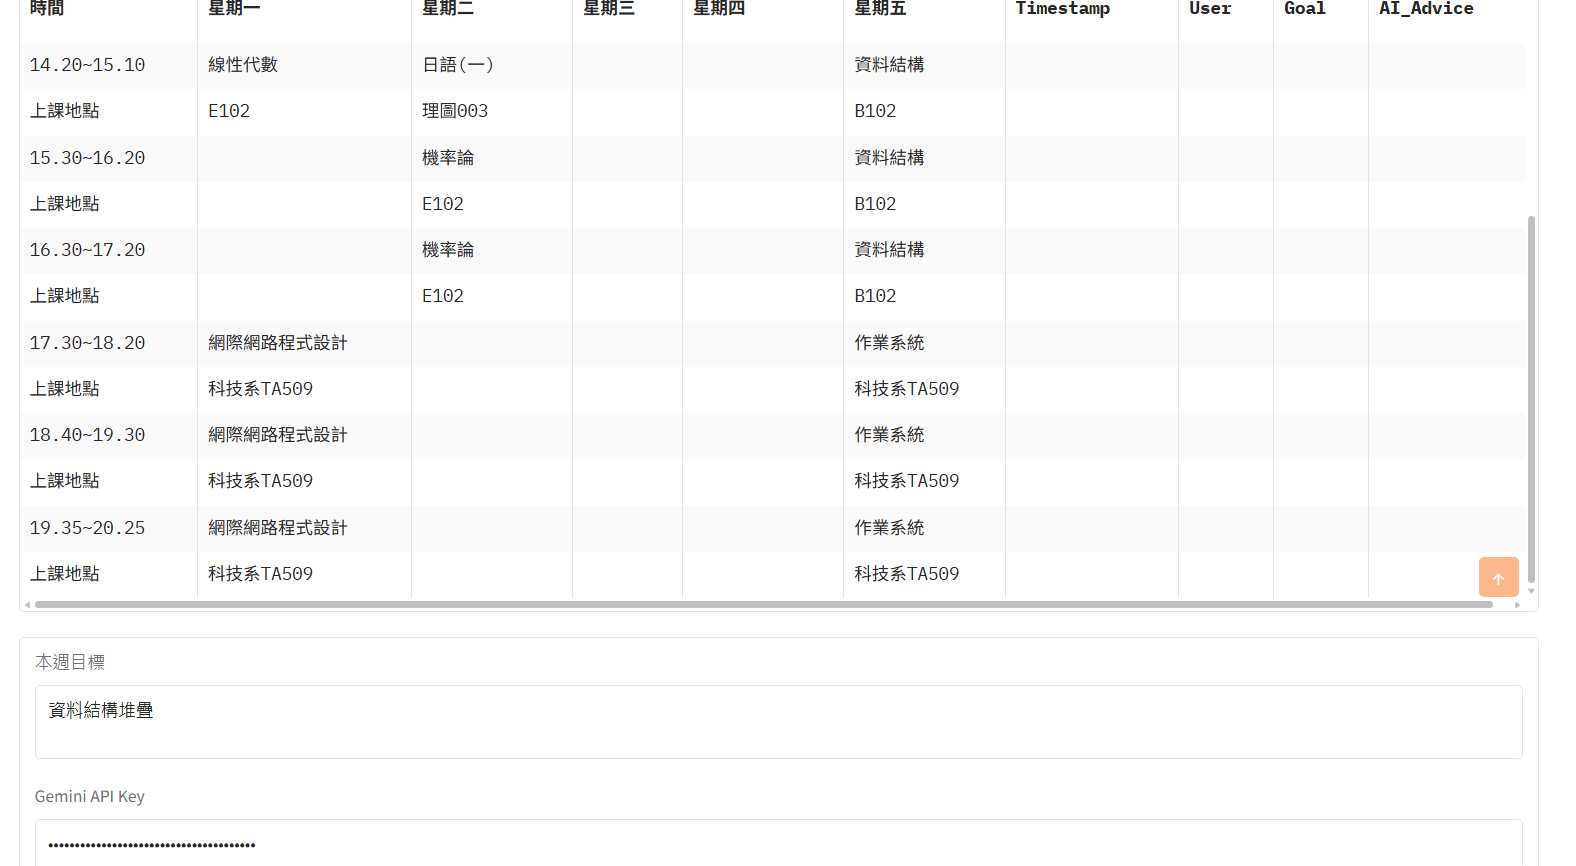

## **新增區段**